# Navigator Model

# import & load data
- 회원: 고객정보데이터 내 성별, 연령에 대한 정보가 있는 clnt_id를 회원으로 간주합니다.
- 비회원: 회원이 아닌 clnt_id를 비회원으로 간주합니다.

## import modules

In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
import missingno as msno
import seaborn as sns

# 그래프 마이너스 기호 깨짐 방지 
matplotlib.rcParams['axes.unicode_minus'] = False
# 그래프 한글 깨짐 방지
font_path = 'C:/Windows/Fonts/malgun.ttf'
fontprop = fm.FontProperties(fname=font_path, size=50)

## load data

In [8]:
cks_dtype = {'clnt_id':'int64','sess_id':'int64','hit_seq':'int64','action_type':'int64','biz_unit':'category','sess_dt':'object','hit_tm':'object',
             'hit_pss_tm':'int64','trans_id':'float64','sech_kwd':'object','tot_pag_view_ct':'float64','tot_sess_hr_v':'float64','trfc_src':'category',
             'dvc_ctg_nm':'object','pd_c':'object','de_dt':'object','de_tm':'object','buy_am':'int64','buy_ct':'int64','clnt_gender':'category'}
df1online = pd.read_csv('./DATA/온라인 행동 정보(CKS).csv', dtype=cks_dtype)
df2trade = pd.read_csv('./DATA/거래 정보(CKS).csv', dtype=cks_dtype)
df3custom = pd.read_csv('./DATA/고객 정보(CKS).csv', dtype=cks_dtype)
df4item = pd.read_csv('./DATA/상품분류 정보(CKS).csv', dtype=cks_dtype)

In [9]:
df1online.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,14.0,124.0,unknown,mobile_app
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,14.0,124.0,unknown,mobile_app
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,14.0,124.0,unknown,mobile_app
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,45.0,424.0,unknown,mobile_app
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,45.0,424.0,unknown,mobile_app


- 거래정보데이터(df2trade)는 clnt_id, trans_seq를 기준으로 정렬합니다.

In [10]:
df2trade.sort_values(by = ['clnt_id', 'trans_seq'], inplace=True)
df2trade.reset_index(drop = True, inplace = True)
df2trade.head()

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct
0,2,42449.0,1,A02,1015.0,20190704,15:34,46430,1
1,2,62037.0,1,A03,92.0,20190729,23:47,36000,20
2,2,64691.0,1,A03,186.0,20190731,21:25,3790,1
3,2,65505.0,1,A03,92.0,20190801,22:00,9000,5
4,2,72330.0,1,A02,857.0,20190809,10:14,34970,1


# data preprocessing
- `df3_known`: 고객정보데이터(df3custom)에서 unknown과 10대를 제외한 뒤 clnt_type을 부여합니다.
    - 여성(F)의 clnt_type 
        - 20대부터 60대까지 각각 0, 1, 2, 3, 4의 clnt_type 부여합니다.
    - 남성(M)의 clnt_type
        - 20대부터 60대까지 각각 5, 6, 7, 8, 9의 clnt_type 부여합니다.
- `df1_known`: 온라인행동정보데이터(df1online)에서 회원만을 추출한 데이터입니다.
- `df1_transO`: df1_known에서 거래가 적어도 한번 발생한 세션만을 추출한 데이터입니다.
- `df2_df4`: 거래정보데이터(df2trade)와 상품정보(df4item)을 병합한 데이터입니다.
- `df_merged`: 네비게이터 모델에서 활용할 데이터프레임을 만드는 과정을 겪는 데이터입니다.

## df3_known
- 고객정보데이터(df3custom)에서 unknown과 10대를 제외한 데이터입니다.
    - 이 데이터에 `clnt_type`을 부여합니다.
    - 부여한 `clnt_type`을 `clnt_id`를 기준으로 온라인행동데이터(df1online)에 join할 예정입니다.

In [11]:
df3_known = df3custom[~df3custom['clnt_gender'].isnull()] # 회원만 가져옵니다.
df3_known = df3_known[df3_known['clnt_age'] != 10].reset_index(drop = True) # 10대 제거
print(df3_known.shape)
df3_known.head()

(12199, 3)


,clnt_id,clnt_gender,clnt_age
0,2,F,30.0
1,9,F,40.0
2,12,F,40.0
3,20,F,30.0
4,22,M,30.0


- clnt_type 변수를 부여합니다.

In [12]:
df3_known['clnt_type'] = 0 # clnt_type 컬럼 생성: 연령과 성별을 고려한 10개의 클래스(20대여성, 30대여성, ... , 60대여성... , 20대남성, 30대남성, .. , 60대남성)

genders = ['F', 'M']
age_group = [20, 30, 40, 50, 60]
k = 0

for gender in genders:
    for age in age_group:
        temp = df3_known[(df3_known['clnt_gender']==gender) & (df3_known['clnt_age'] == age)].index
        df3_known.loc[temp, 'clnt_type'] = k
        k+=1

df3_known['clnt_type'].value_counts()

2    4200
1    3680
3    1435
0     762
7     748
6     627
8     259
4     241
5     162
9      85
Name: clnt_type, dtype: int64

- 데이터 저장

In [ ]:
df3_known.to_csv('./navigator/#1 df3_known.csv', index = False)

- 데이터 불러오기

In [ ]:
df3_known = pd.read_csv('./navigator/#1 df3_known.csv')
df3_known.head()

## df1_known
- 온라인행동정보데이터(df1online)에서 회원만 추출한 데이터입니다.

In [13]:
df1_known = df1online[df1online['clnt_id'].isin(df3_known['clnt_id'].to_list())]
df1_known = df1_known.sort_values(by = ['clnt_id', 'sess_id', 'hit_seq']).reset_index(drop = True)
df1_known.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
0,2,1,1,0,A03,20190728,23:35,39532,NaN,레쓰비,61.0,911.0,DIRECT,unknown
1,2,1,2,1,A03,20190728,23:35,47232,NaN,NaN,61.0,911.0,DIRECT,unknown
2,2,1,3,2,A03,20190728,23:35,48087,NaN,NaN,61.0,911.0,DIRECT,unknown
3,2,1,4,0,A03,20190728,23:35,62794,NaN,레쓰비,61.0,911.0,DIRECT,unknown
4,2,1,5,0,A03,20190728,23:36,104074,NaN,레쓰비,61.0,911.0,DIRECT,unknown


- 데이터 저장

In [ ]:
df1_known.to_csv('./navigator/#2 df1_known.csv', index = False)
# 데이터 불러오기
df1_known = pd.read_csv('./navigator/#2 df1_known.csv')

## df1_transO
- df1_known에서 거래가 발생한 세션만을 추출한 데이터입니다.
    - 거래가 적어도 한번 발생한 세션들을 추출했습니다.

In [15]:
# 거래정보(trans_id)를 적어도 하나 가지고있는(결측값이 아닌) 세션만을 가져오기 위한 사용자정의함수입니다.
def det_(df):
    nrows = df.shape[0]
    if df['trans_id'].isnull().value_counts().iloc[0] != nrows:
        return df

In [27]:
# trans_id 가 있는 세션만 가져옴
df1_transO = df1_known.groupby(['clnt_id', 'sess_id']).apply(lambda x : det_(x))

In [28]:
df1_transO.reset_index(drop = True, inplace = True)

In [29]:
df1_transO.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
0,2,1,1,0,A03,20190728,23:35,39532,NaN,레쓰비,61.0,911.0,DIRECT,unknown
1,2,1,2,1,A03,20190728,23:35,47232,NaN,NaN,61.0,911.0,DIRECT,unknown
2,2,1,3,2,A03,20190728,23:35,48087,NaN,NaN,61.0,911.0,DIRECT,unknown
3,2,1,4,0,A03,20190728,23:35,62794,NaN,레쓰비,61.0,911.0,DIRECT,unknown
4,2,1,5,0,A03,20190728,23:36,104074,NaN,레쓰비,61.0,911.0,DIRECT,unknown


- 데이터 저장

In [ ]:
df1_transO.to_csv('./navigator/#3 df1_transO.csv',index = False)
# 데이터 불러오기
df1_transO = pd.read_csv('./navigator/#3 df1_transO.csv')

- 데이터 불러오기

In [ ]:
df1_transO = pd.read_csv('./navigator/#3 df1_transO.csv')

## df2_df4
- 거래정보데이터(df2trade)와 상품정보(df4item)을 병합한 데이터
    - `pd_c`를 기준으로 join

In [30]:
df2_df4 = df2trade.merge(df4item, how = 'left')
df2_df4.head()

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clac_nm1,clac_nm2,clac_nm3
0,2,42449.0,1,A02,1015.0,20190704,15:34,46430,1,Men's Clothing,Men's Upper Bodywear / Tops,Men's T-shirts
1,2,62037.0,1,A03,92.0,20190729,23:47,36000,20,Beverages,Coffee Drinks,Coffee Drinks
2,2,64691.0,1,A03,186.0,20190731,21:25,3790,1,Chilled Foods,Fish Cakes and Crab Sticks,Crab Sticks
3,2,65505.0,1,A03,92.0,20190801,22:00,9000,5,Beverages,Coffee Drinks,Coffee Drinks
4,2,72330.0,1,A02,857.0,20190809,10:14,34970,1,Kids' Clothing,Preschoolers' Upper Bodywear / Tops,Infant / Toddlers' T-shirts / Tops


- 데이터 저장

In [ ]:
df2_df4.to_csv('./navigator/#4 df2_df4.csv',index = False)

- 저장해둔 데이터 불러오기

In [ ]:
df2_df4 = pd.read_csv('./navigator/#4 df2_df4.csv')

## 네비게이터 모델에 맞는 데이터프레임 형성
---
- #1: `df_merged`데이터
    - df1_transO 데이터와 df2_df4 데이터를 병합한 뒤, 이 데이터를 df3_known 데이터와 병합한 데이터입니다. 
    - 결과적으로 거래정보와 구매한 상품의 정보, 그리고 `clnt_type`이 추가되었고, 거래가 발생한 세션들만 추출한 데이터입니다.
---
- #2: `buy_id`변수 생성
    - 구매발생 단위로 데이터에 접근하기 위해 `buy_id`변수를 생성합니다. 세션 내 구매 간 행동을 구분해주는 ID입니다.
        - (예) clnt_id, sess_id 가 모두 1인 고객의 hit_seq가 10까지 있는 경우를 생각해보겠습니다. 
        - 만약 hit_seq가 4와 10에 발생했을 경우 두 번의 구매가 발생한 것입니다.
        - 이 경우 hit_seq 1\~4의 buy_id가 1, hit_seq 5\~10의 buy_id는 2로 매깁니다.
        - 또한 buy_id가 0인 경우는 구매 발생과 관련이 없는 것으로 간주하여 학습에서 제외하였습니다.
---
- #3 `except_7()`: 구매환불(7)이 포함된 세션은 제외
    - 거래정보가 발생한 경우는 구매완료(6), 구매환불(7) 두 행동이 있습니다.
    - 거래 중 구매가 발생한 데이터만을 학습 데이터로 활용하기 위해 구매환불이 발생한 데이터는 제외합니다.
---
- #4 `hit_tm_class` 변수 생성
    - `hit_tm`을 시간대별  분류를 통해 카테고리화하였습니다.
        - (예) 23:35 -> 23, 23:47 -> 23
- #4 `realtime` 변수 생성
    - 고객의 실시간 행동을 반영하는 변수입니다.
        - `realtime_hit_pss_tm`: 다음 행동이 구매완료(6)라고 할 때, 구매 발생까지 걸린 시간(밀리초)
        - `realtime_hit_seq`: 다음 행동이 구매완료(6)라고 할 때,구매 발생까지의 히트시퀀스 수
        - `realtime_num_kwds` : 다음 행동이 구매완료(6)라고 할 때,구매 발생까지의 검색어 수
- #5 `latest` 변수 생성
    - 과거의 행적을 담은 변수입니다.
    - `latest_kwd`: 구매 이전에 검색을 했을 경우 어떤 키워드를 검색했는지에 대한 정보를 담은 변수입니다.
        - `latest_kwd_1`~`latest_kwd_6`: 가장 최근 검색한 6개의 검색어를 반영합니다.
    - `latest_pv_hr`
        - `pv_hr`은 온라인행동데이터의 `세션내총페이지뷰수/세션내총시간`으로 단위 페이지당 머무른 시간을 나타내는 서핑속도입니다.
        - `latest_pv_hr_1` \~ `latest_pv_hr_3`: 최근 쇼핑의 3개의 페이지 서핑 속도를 반영합니다.
- #6 `scorch`: 외부데이터: 날짜별 더위체감지수(정오기준)
- #7 `pm2.5`: 외부데이터: 날짜별 초미세먼지 농도(평균값)
- #8 `pm10`: 외부데이터: 날짜별 미세먼지 농도(평균값)

In [31]:
df_merged = df1_transO.merge(df2_df4, how = 'left').reset_index(drop = True)
df_merged = df_merged.merge(df3_known[['clnt_id', 'clnt_type']], how ='left')
df_merged.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,trans_seq,pd_c,de_dt,de_tm,buy_am,buy_ct,clac_nm1,clac_nm2,clac_nm3,clnt_type
0,2,1,1,0,A03,20190728,23:35,39532,NaN,레쓰비,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2,1,2,1,A03,20190728,23:35,47232,NaN,NaN,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2,1,3,2,A03,20190728,23:35,48087,NaN,NaN,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2,1,4,0,A03,20190728,23:35,62794,NaN,레쓰비,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2,1,5,0,A03,20190728,23:36,104074,NaN,레쓰비,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


### `buy_id` 변수 생성
- 구매발생 단위로 데이터에 접근하기 위해 `buy_id`변수를 생성합니다. 세션 내 구매 간 행동을 구분해주는 ID입니다.
    - (예) clnt_id, sess_id 가 모두 1인 고객의 hit_seq가 10까지 있는 경우를 생각해보겠습니다. 
    - 만약 hit_seq가 4와 10에 구매가 발생했을 경우 두 번의 구매가 발생한 것입니다.
    - 이 경우 hit_seq 1\~4의 buy_id가 1, hit_seq 5\~10의 buy_id는 2가 됩니다.
    - 또한 buy_id가 0인 경우는 구매 발생과 관련이 없는 것으로 간주하여 학습에서 제외하였습니다.

In [32]:
def buy_id(df):
    trans_list = list(df[~df['trans_id'].isnull()]['trans_id'].unique())
    idx_list = [df.index[0]]
    for i in trans_list:
        idx_list.append(df[df['trans_id'] == i].index.max())
    for j in range(len(idx_list)-1):
        if j == 0:
            df.loc[idx_list[j] : idx_list[j+1], 'buy_id'] = j+1
        else:
            df.loc[ idx_list[j]+1 :idx_list[j+1], 'buy_id'] = j+1
    return df

def except_7(df):
    temp = df[~df['trans_id'].isnull()]['action_type'].to_list()
    if 7 not in temp:
        return df
    else:
        return pd.DataFrame()

In [33]:
df_merged['buy_id'] = 0
df_merged = df_merged.groupby(['clnt_id', 'sess_id']).apply(lambda x: buy_id(x))
df_merged = df_merged.groupby(['clnt_id', 'sess_id', 'buy_id']).apply(lambda x: except_7(x))
df_merged.reset_index(drop = True, inplace = True)
df_merged = df_merged[df_merged['buy_id'] != 0].reset_index(drop = True)

# 구매환불(7)을 제거하는 과정에서 buy_id가 도약하는 문제가 발생했으므로 buy_id를 다시 매겨줌
df_merged['buy_id'] = 0
df_merged = df_merged.groupby(['clnt_id', 'sess_id']).apply(lambda x: buy_id(x))
df_merged = df_merged[df_merged['buy_id'] != 0].reset_index(drop = True)

df_merged.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,trans_seq,pd_c,de_dt,de_tm,buy_am,buy_ct,clac_nm1,clac_nm2,clac_nm3,clnt_type,buy_id
0,2.0,1.0,1.0,0.0,A03,20190728,23:35,39532.0,NaN,레쓰비,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1
1,2.0,1.0,2.0,1.0,A03,20190728,23:35,47232.0,NaN,NaN,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1
2,2.0,1.0,3.0,2.0,A03,20190728,23:35,48087.0,NaN,NaN,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1
3,2.0,1.0,4.0,0.0,A03,20190728,23:35,62794.0,NaN,레쓰비,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1
4,2.0,1.0,5.0,0.0,A03,20190728,23:36,104074.0,NaN,레쓰비,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1


### `hit_tm_class` 변수 생성
- `hit_tm`을 시간대별  분류를 통해 카테고리화하였습니다.

In [34]:
def time_to_int(x):
    return int(x.split(':')[0])

In [35]:
df_merged['hit_tm_class'] = df_merged['hit_tm'].apply(lambda x: time_to_int(x))
df_merged.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,trans_seq,pd_c,de_dt,de_tm,buy_am,buy_ct,clac_nm1,clac_nm2,clac_nm3,clnt_type,buy_id,hit_tm_class
0,2.0,1.0,1.0,0.0,A03,20190728,23:35,39532.0,NaN,레쓰비,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23
1,2.0,1.0,2.0,1.0,A03,20190728,23:35,47232.0,NaN,NaN,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23
2,2.0,1.0,3.0,2.0,A03,20190728,23:35,48087.0,NaN,NaN,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23
3,2.0,1.0,4.0,0.0,A03,20190728,23:35,62794.0,NaN,레쓰비,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23
4,2.0,1.0,5.0,0.0,A03,20190728,23:36,104074.0,NaN,레쓰비,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23


### `realtime` 변수 생성
- `realtime_hit_pss_tm` : 구매가 발생하기까지 걸린 시간(밀리초)
- `realtime_hit_seq` : 구매가 발생하기까지 히트시퀀스 수
- `realtime_num_kwds`: 구매가 발생하기까지 검색어 수
    - 평균 : 4.5회
    - 중앙값 : 2회
    - 상위 75% : 6회 이상

#### `realtime_hit_pss_tm`: 구매가 발생하기까지 걸린 시간(밀리초)

In [36]:
def realtime_hit_pss_tm(df):
    if df['buy_id'].nunique() > 1:
        id_list = list(df['buy_id'].unique())
        for i in id_list:
            if i > 1:
                temp_idx = df[df['buy_id'] == i].index
                tail_value = df[df['buy_id'] == i-1]['hit_pss_tm'].iloc[-1]
                df.loc[temp_idx, 'realtime_hit_pss_tm'] = df.loc[temp_idx, 'hit_pss_tm'] - tail_value
            else:
                temp_idx = df[df['buy_id'] == i].index
                df.loc[temp_idx, 'realtime_hit_pss_tm'] = df.loc[temp_idx, 'hit_pss_tm']
    else:
        df['realtime_hit_pss_tm'] = df['hit_pss_tm']
    return df

In [37]:
df_merged =  df_merged.groupby(['clnt_id', 'sess_id']).apply(lambda x: realtime_hit_pss_tm(x))

In [38]:
df_merged[['clnt_id', 'sess_id', 'buy_id', 'realtime_hit_pss_tm']].head()

,clnt_id,sess_id,buy_id,realtime_hit_pss_tm
0,2.0,1.0,1,39532.0
1,2.0,1.0,1,47232.0
2,2.0,1.0,1,48087.0
3,2.0,1.0,1,62794.0
4,2.0,1.0,1,104074.0


#### `realtime_hit_seq`: 구매가 발생하기까지의 히트시퀀스 수

In [39]:
def realtime_hit_seq(df):
    if df['buy_id'].nunique() > 1:
        id_list = list(df['buy_id'].unique())
        for i in id_list:
            if i > 1:
                temp_idx = df[df['buy_id'] == i].index
                tail_value = df[df['buy_id'] == i-1]['hit_seq'].iloc[-1]
                df.loc[temp_idx, 'realtime_hit_seq'] = df.loc[temp_idx, 'hit_seq'] - tail_value
            else:
                temp_idx = df[df['buy_id'] == i].index
                df.loc[temp_idx, 'realtime_hit_seq'] = df.loc[temp_idx, 'hit_seq']
    else:
        df['realtime_hit_seq'] = df['hit_seq']
    return df

In [40]:
df_merged = df_merged.groupby(['clnt_id', 'sess_id']).apply(lambda x: realtime_hit_seq(x))

In [41]:
df_merged[['clnt_id', 'sess_id', 'buy_id', 'realtime_hit_seq']].head()

,clnt_id,sess_id,buy_id,realtime_hit_seq
0,2.0,1.0,1,1.0
1,2.0,1.0,1,2.0
2,2.0,1.0,1,3.0
3,2.0,1.0,1,4.0
4,2.0,1.0,1,5.0


#### `realtime_num_kwds` : 구매가 발생하기까지의 검색횟수(=검색 action의 발생 횟수)

In [42]:
df_merged['realtime_num_kwds'] = 0 # 초기값을 넣어줌

In [43]:
def realtime_num_kwds(df):
    for i in range(len(df)): # buy_id 씩 끊어서 반복문 
        if i >= 1: # i = 0인건 제외하고 
            temp_df = df.iloc[ : i , :] # i 이전까지에 대하여 검색어가 있는 로우 개수가 i번째 로우값에 들어가 
            df.iloc[i, -1] = len(temp_df[~temp_df['sech_kwd'].isnull()])
    return df

In [44]:
df_merged = df_merged.groupby(['clnt_id', 'sess_id', 'buy_id']).apply(lambda x: realtime_num_kwds(x))

In [45]:
df_merged[['clnt_id', 'sess_id', 'buy_id', 'sech_kwd', 'realtime_num_kwds']].head(10)

,clnt_id,sess_id,buy_id,sech_kwd,realtime_num_kwds
0,2.0,1.0,1,레쓰비,0
1,2.0,1.0,1,NaN,1
2,2.0,1.0,1,NaN,1
3,2.0,1.0,1,레쓰비,1
4,2.0,1.0,1,레쓰비,2
5,2.0,1.0,1,NaN,3
6,2.0,1.0,1,NaN,3
7,2.0,1.0,1,NaN,3
8,2.0,1.0,1,레쓰비,3
9,2.0,1.0,1,NaN,4


- `realtime_num_kwds`의 분포탐색: 사용자들은 보통 몇번의 검색을 하느냐
    - 최소: 0회
    - 평균: 4.5회
    - 중앙값: 2회
    - 상위75%: 6회이상

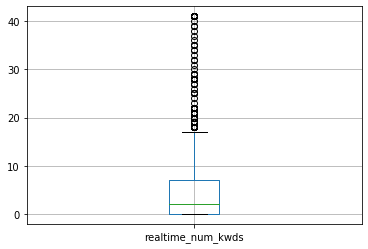

In [46]:
df_merged.boxplot(column='realtime_num_kwds')

In [47]:
df_merged['realtime_num_kwds'].describe()

count    4058.000000
mean        4.578610
std         6.409135
min         0.000000
25%         0.000000
50%         2.000000
75%         7.000000
max        41.000000
Name: realtime_num_kwds, dtype: float64

- 데이터 저장

In [ ]:
df_merged.to_csv('./navigator/#5 df_merged.csv', index = False)

- 저장한 데이터 불러오기

In [ ]:
df_merged = pd.read_csv('./navigator/#5 df_merged.csv')

### `latest` 변수 생성
- `latest_kwd_1` \~ `latest_kwd_6`
- `latest_pv_hr_1` \~ `latest_pv_hr_3`

##### `latest_kwd`
- `latest_kwd`: 구매 이전에 검색을 했을 경우 어떤 키워드를 검색했는지에 대한 정보를 담은 변수입니다.
    - `latest_kwd_1` : 구매로부터 가장 최근의 검색키워드입니다.
    - ~ `latest_kwd_6`: 구매로부터 6번째로 오래된 검색키워드입니다.
- 만약 검색어가 발생하지 않았다면 -1로 처리하여 별도의 카테고리에 속하도록 했습니다.
- (예) 'Beverage'를 구매한 사용자가 구매발생 이전에 3번의 검색만을 한 경우 `latest_kwd_4` \~ `latest_kwd_6`은 -1이 됩니다. 

In [48]:
def latest_kwds(df):
    for j in range(len(df)):
        if j > 0:
            temp_df = df.iloc[ : j , :]
            temp_idx = temp_df.tail(1).index
            kwd_list = temp_df[~temp_df['sech_kwd'].isnull()]['sech_kwd'].tail(6).tolist()
            kwd_list.reverse()
            if len(kwd_list) > 0:
                for idx, i in enumerate(kwd_list) :
                    df.loc[temp_idx+1, f'latest_kwd_{idx+1}'] = i
    return df

In [49]:
# 먼저 latest_kwd_x 컬럼 생성
for i in range(1, 7):
    df_merged[f'latest_kwd_{i}'] = -1

In [50]:
df_merged = df_merged.groupby(['clnt_id', 'sess_id', 'buy_id']).apply(lambda x: latest_kwds(x))

In [51]:
df_merged[['clnt_id', 'sess_id', 'buy_id', 'hit_seq', 'sech_kwd', 'realtime_num_kwds', 
           'latest_kwd_1', 'latest_kwd_2', 'latest_kwd_3', 'latest_kwd_4', 'latest_kwd_5', 'latest_kwd_6']].head()

,clnt_id,sess_id,buy_id,hit_seq,sech_kwd,realtime_num_kwds,latest_kwd_1,latest_kwd_2,latest_kwd_3,latest_kwd_4,latest_kwd_5,latest_kwd_6
0,2.0,1.0,1,1.0,레쓰비,0,-1,-1,-1,-1,-1,-1
1,2.0,1.0,1,2.0,NaN,1,레쓰비,-1,-1,-1,-1,-1
2,2.0,1.0,1,3.0,NaN,1,레쓰비,-1,-1,-1,-1,-1
3,2.0,1.0,1,4.0,레쓰비,1,레쓰비,-1,-1,-1,-1,-1
4,2.0,1.0,1,5.0,레쓰비,2,레쓰비,레쓰비,-1,-1,-1,-1


- 데이터 저장

In [ ]:
df_merged.to_csv('./navigator/#6 df_merged_six_kwds.csv',index = False)

##### `latest_pv_hr`
- `pv_hr`은 온라인행동데이터의 `세션내총페이지뷰수/세션내총시간`으로 단위 페이지당 머무른 시간을 나타내는 서핑속도입니다.
- 우선 회원별 세션 수의 분포 탐색을 해보겠습니다.

In [52]:
temp = df_merged.groupby('clnt_id').apply(lambda x: x['sess_id'].nunique()).to_frame()
# 중간값 1 이상
# 상위75% 이상 3 이상
# 과거 3개의 세션에 대한 과거 정보를 담자
temp.describe()

,0
count,58.000000
mean,2.241379
std,3.540792
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,24.000000


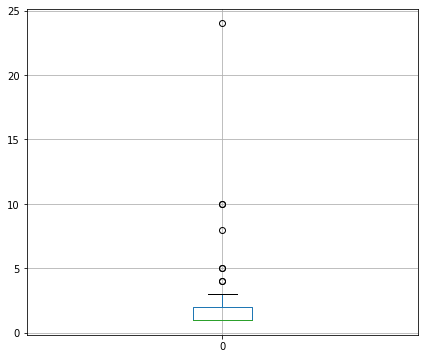

In [53]:
temp.boxplot(column = 0, figsize= (7,6))

- 사용자의 세션수의 분포에 대한 탐색 결과 상위 75% 이상이 3개 이상의 세션 수를 지니고 있습니다. 이에 따라 3번째 이전의 세션까지 pv_hr을 변수로 반영하였습니다.(위는 1만개 고객 데이터만을 반영하였을 경우에 대한 그래프입니다)
    - `latest_pv_hr_1`: 가장 최근 구매가 발생한 과거의 세션의 pv_hr입니다.
    - ~ `latest_pv_hr_3`: 세번째로 오래된 구매가 발생한 세션의 pv_hr입니다.

-  온라인행동데이터에 `pv_hr`변수를 생성하고 이를 df_merged에 join합니다.

In [54]:
df1online['pv_hr'] = df1online['tot_pag_view_ct'] /  df1online['tot_sess_hr_v']
temp = df1online[['clnt_id', 'sess_id', 'tot_pag_view_ct', 'tot_sess_hr_v', 'pv_hr']]
df_pv_hr = temp.groupby(['clnt_id', 'sess_id'], as_index = False).first().reset_index(drop = True)
df_pv_hr.head()

,clnt_id,sess_id,tot_pag_view_ct,tot_sess_hr_v,pv_hr
0,1,1,14.0,124.0,0.112903
1,1,2,45.0,424.0,0.106132
2,2,1,61.0,911.0,0.066959
3,2,2,12.0,134.0,0.089552
4,2,3,12.0,942.0,0.012739


In [55]:
df_merged = df_merged.merge(df_pv_hr, how = 'left')

- `lastest_pv_hr`변수를 생성합니다. 

In [56]:
df_merged['latest_pv_hr_1'] = 0
df_merged['latest_pv_hr_2'] = 0
df_merged['latest_pv_hr_3'] = 0
df_merged.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,trans_seq,pd_c,de_dt,de_tm,buy_am,buy_ct,clac_nm1,clac_nm2,clac_nm3,clnt_type,buy_id,hit_tm_class,realtime_hit_pss_tm,realtime_hit_seq,realtime_num_kwds,latest_kwd_1,latest_kwd_2,latest_kwd_3,latest_kwd_4,latest_kwd_5,latest_kwd_6,pv_hr,latest_pv_hr_1,latest_pv_hr_2,latest_pv_hr_3
0,2.0,1.0,1.0,0.0,A03,20190728,23:35,39532.0,NaN,레쓰비,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23,39532.0,1.0,0,-1,-1,-1,-1,-1,-1,0.066959,0,0,0
1,2.0,1.0,2.0,1.0,A03,20190728,23:35,47232.0,NaN,NaN,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23,47232.0,2.0,1,레쓰비,-1,-1,-1,-1,-1,0.066959,0,0,0
2,2.0,1.0,3.0,2.0,A03,20190728,23:35,48087.0,NaN,NaN,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23,48087.0,3.0,1,레쓰비,-1,-1,-1,-1,-1,0.066959,0,0,0
3,2.0,1.0,4.0,0.0,A03,20190728,23:35,62794.0,NaN,레쓰비,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23,62794.0,4.0,1,레쓰비,-1,-1,-1,-1,-1,0.066959,0,0,0
4,2.0,1.0,5.0,0.0,A03,20190728,23:36,104074.0,NaN,레쓰비,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23,104074.0,5.0,2,레쓰비,레쓰비,-1,-1,-1,-1,0.066959,0,0,0


In [57]:
def latest_pv_hr(df):
    temp_df = df[['sess_id', 'pv_hr']].groupby('sess_id').first()
    for s in df['sess_id'].unique():
        temp = temp_df[temp_df.index < s].tail(3)
        temp_idx = df[df['sess_id'] == s].index
        for i in range(len(temp)):
              df.loc[temp_idx, f'latest_pv_hr_{i+1}'] = temp.iloc[-(i+1), 0]
    return df    

In [58]:
df_merged = df_merged.groupby('clnt_id').apply(lambda x : latest_pv_hr(x))

In [59]:
df_merged.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,trans_seq,pd_c,de_dt,de_tm,buy_am,buy_ct,clac_nm1,clac_nm2,clac_nm3,clnt_type,buy_id,hit_tm_class,realtime_hit_pss_tm,realtime_hit_seq,realtime_num_kwds,latest_kwd_1,latest_kwd_2,latest_kwd_3,latest_kwd_4,latest_kwd_5,latest_kwd_6,pv_hr,latest_pv_hr_1,latest_pv_hr_2,latest_pv_hr_3
0,2.0,1.0,1.0,0.0,A03,20190728,23:35,39532.0,NaN,레쓰비,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23,39532.0,1.0,0,-1,-1,-1,-1,-1,-1,0.066959,0.0,0.0,0.0
1,2.0,1.0,2.0,1.0,A03,20190728,23:35,47232.0,NaN,NaN,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23,47232.0,2.0,1,레쓰비,-1,-1,-1,-1,-1,0.066959,0.0,0.0,0.0
2,2.0,1.0,3.0,2.0,A03,20190728,23:35,48087.0,NaN,NaN,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23,48087.0,3.0,1,레쓰비,-1,-1,-1,-1,-1,0.066959,0.0,0.0,0.0
3,2.0,1.0,4.0,0.0,A03,20190728,23:35,62794.0,NaN,레쓰비,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23,62794.0,4.0,1,레쓰비,-1,-1,-1,-1,-1,0.066959,0.0,0.0,0.0
4,2.0,1.0,5.0,0.0,A03,20190728,23:36,104074.0,NaN,레쓰비,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23,104074.0,5.0,2,레쓰비,레쓰비,-1,-1,-1,-1,0.066959,0.0,0.0,0.0


- 데이터 저장

In [ ]:
df_merged.to_csv('./navigator/#6-3 df_merged_latest_all.csv', index = False)

- 저장한 데이터 불러오기

In [ ]:
df_merged = pd.read_csv('./navigator/#6-3 df_merged_latest_all.csv')

### 외부데이터 변수 및 요일 변수 추가
- 날짜에 따라 상품의 분포가 상이함에 따라 날짜와 관련한 외부데이터를 활용하였습니다.
- 더위체감지수: `scorch`
- 미세먼지: `pm2.5`, `pm10`

#### 외부데이터 변수 추가
- 더위체감지수: `scorch`
- 미세먼지: `pm2.5`, `pm10`

In [60]:
df_hot = pd.read_csv('./DATA/외부데이터_더위체감지수(정오기준).csv')
df_dust = pd.read_csv('./DATA/외부데이터_미세먼지.csv')

- 데이터는 아래와 같고 `sess_dt`를 공통 변수로 df_merged 데이터와 join하겠습니다.

In [64]:
display(df_hot.head(3))
display(df_dust.head(3))

,sess_dt,scorch
0,20190701,22
1,20190702,23
2,20190703,24


,sess_dt,pm2.5,pm10
0,20190701,25,34
1,20190702,22,30
2,20190703,23,33


In [76]:
df_merged['sess_dt'] = df_merged['sess_dt'].astype('int')
df_merged = df_merged.merge(df_hot, how ='left')
df_merged = df_merged.merge(df_dust, how = 'left')
df_merged.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,trans_seq,pd_c,de_dt,de_tm,buy_am,buy_ct,clac_nm1,clac_nm2,clac_nm3,clnt_type,buy_id,hit_tm_class,realtime_hit_pss_tm,realtime_hit_seq,realtime_num_kwds,latest_kwd_1,latest_kwd_2,latest_kwd_3,latest_kwd_4,latest_kwd_5,latest_kwd_6,pv_hr,latest_pv_hr_1,latest_pv_hr_2,latest_pv_hr_3,weekday,scorch,pm2.5,pm10
0,2.0,1.0,1.0,0.0,A03,20190728,23:35,39532.0,NaN,레쓰비,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23,39532.0,1.0,0,-1,-1,-1,-1,-1,-1,0.066959,0.0,0.0,0.0,6,25,9,14
1,2.0,1.0,2.0,1.0,A03,20190728,23:35,47232.0,NaN,NaN,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23,47232.0,2.0,1,레쓰비,-1,-1,-1,-1,-1,0.066959,0.0,0.0,0.0,6,25,9,14
2,2.0,1.0,3.0,2.0,A03,20190728,23:35,48087.0,NaN,NaN,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23,48087.0,3.0,1,레쓰비,-1,-1,-1,-1,-1,0.066959,0.0,0.0,0.0,6,25,9,14
3,2.0,1.0,4.0,0.0,A03,20190728,23:35,62794.0,NaN,레쓰비,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23,62794.0,4.0,1,레쓰비,-1,-1,-1,-1,-1,0.066959,0.0,0.0,0.0,6,25,9,14
4,2.0,1.0,5.0,0.0,A03,20190728,23:36,104074.0,NaN,레쓰비,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23,104074.0,5.0,2,레쓰비,레쓰비,-1,-1,-1,-1,0.066959,0.0,0.0,0.0,6,25,9,14


- 데이터 저장

In [ ]:
df_merged.to_csv('./navigator/#6-4 df_merged_dust_scorch.csv', index = False)

- 저장한 데이터 불러오기

In [ ]:
df_merged = pd.read_csv('./navigator/#6-4 df_merged_dust_scorch.csv')

#### 요일변수 추가
- 트래커모델과 마찬가지로 요일변수를 추가합니다.

`0:월 / 1:화 / 2:수 / 3:목 / 4:금 / 5:토 / 6:일` 로 맵핑됩니다.

In [77]:
df_merged['weekday'] = pd.to_datetime(df_merged['sess_dt'], format='%Y%m%d').apply(lambda x: x.weekday())

In [78]:
df_merged.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,trans_seq,pd_c,de_dt,de_tm,buy_am,buy_ct,clac_nm1,clac_nm2,clac_nm3,clnt_type,buy_id,hit_tm_class,realtime_hit_pss_tm,realtime_hit_seq,realtime_num_kwds,latest_kwd_1,latest_kwd_2,latest_kwd_3,latest_kwd_4,latest_kwd_5,latest_kwd_6,pv_hr,latest_pv_hr_1,latest_pv_hr_2,latest_pv_hr_3,weekday,scorch,pm2.5,pm10
0,2.0,1.0,1.0,0.0,A03,20190728,23:35,39532.0,NaN,레쓰비,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23,39532.0,1.0,0,-1,-1,-1,-1,-1,-1,0.066959,0.0,0.0,0.0,6,25,9,14
1,2.0,1.0,2.0,1.0,A03,20190728,23:35,47232.0,NaN,NaN,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23,47232.0,2.0,1,레쓰비,-1,-1,-1,-1,-1,0.066959,0.0,0.0,0.0,6,25,9,14
2,2.0,1.0,3.0,2.0,A03,20190728,23:35,48087.0,NaN,NaN,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23,48087.0,3.0,1,레쓰비,-1,-1,-1,-1,-1,0.066959,0.0,0.0,0.0,6,25,9,14
3,2.0,1.0,4.0,0.0,A03,20190728,23:35,62794.0,NaN,레쓰비,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23,62794.0,4.0,1,레쓰비,-1,-1,-1,-1,-1,0.066959,0.0,0.0,0.0,6,25,9,14
4,2.0,1.0,5.0,0.0,A03,20190728,23:36,104074.0,NaN,레쓰비,61.0,911.0,DIRECT,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,23,104074.0,5.0,2,레쓰비,레쓰비,-1,-1,-1,-1,0.066959,0.0,0.0,0.0,6,25,9,14


- 데이터 저장

In [ ]:
df_merged.to_csv('./navigator/#6-5 df_merged_weekday.csv', index=  False)

- 저장한 데이터 불러오기

In [ ]:
df_merged = pd.read_csv('./navigator/#6-5 df_merged_weekday.csv')

### df_navigator
- 네비게이터 모델의 예측 첫 단계는 구매 상품의 대분류(`clac_nm1`)예측입니다.
- 대분류를 예측하고 이를 다시 특징변수로 받아 중분류를 예측, 그리고 소분류를 예측합니다.
- `df_merge`데이터의 실제 구매 대분류 상품(`clac_nm1`)을 모델의 예측타겟으로 사용하였습니다.
- '상품을 구매하기 전까지 사용자는 그 상품을 구매하기 위해 행동한 것이다'라는 전제를 따라 학습이 진행됩니다.
    - 가령 사용자가 'Beverages'를 구매하기에 앞선 행동들은 모두 'Beverages'를 위한 행동인 것입니다.
    - 이 가정에 따라 한 `buy_id`에서 발생한 구매상품이 해당 `buy_id`의 모든 시퀀스의 타겟값이 됩니다.

In [79]:
# clnt_id, trans_id는 뒤에서 target_merge를 위해 남겨두었습니다.
df_navigator_raw = df_merged[['clnt_id', 'clnt_type', 'sess_id', 'buy_id', 'hit_seq', 'action_type', 'biz_unit', 'trans_id', 'sess_dt', 'hit_pss_tm',
                    'trfc_src', 'dvc_ctg_nm','hit_tm_class', 
                    'realtime_hit_pss_tm','realtime_hit_seq', 'realtime_num_kwds', 
                    'latest_kwd_1','latest_kwd_2', 'latest_kwd_3', 'latest_kwd_4', 'latest_kwd_5','latest_kwd_6', 
                    'latest_pv_hr_1', 'latest_pv_hr_2','latest_pv_hr_3', 
                    'clac_nm1', 'clac_nm2', 'clac_nm3',
                    'scorch', 'pm2.5', 'pm10', 'weekday']]

In [80]:
def target_merge(df):
    temp = df[~df['trans_id'].isnull()].reset_index(drop = True)
    temp['target'] = temp['clac_nm1']
    temp = temp[['clnt_id', 'sess_id', 'target']]
    return df.merge(temp, how= 'left')

In [82]:
df_navigator_raw = df_navigator_raw.groupby(['clnt_id', 'sess_id'], as_index = False).apply(lambda x : target_merge(x))
df_navigator_raw.reset_index(drop = True, inplace = True)

In [83]:
df_navigator_raw.head()

,clnt_id,clnt_type,sess_id,buy_id,hit_seq,action_type,biz_unit,trans_id,sess_dt,hit_pss_tm,trfc_src,dvc_ctg_nm,hit_tm_class,realtime_hit_pss_tm,realtime_hit_seq,realtime_num_kwds,latest_kwd_1,latest_kwd_2,latest_kwd_3,latest_kwd_4,latest_kwd_5,latest_kwd_6,latest_pv_hr_1,latest_pv_hr_2,latest_pv_hr_3,clac_nm1,clac_nm2,clac_nm3,scorch,pm2.5,pm10,weekday,target
0,2.0,1.0,1.0,1,1.0,0.0,A03,NaN,20190728,39532.0,DIRECT,unknown,23,39532.0,1.0,0,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,NaN,NaN,NaN,25,9,14,6,Beverages
1,2.0,1.0,1.0,1,2.0,1.0,A03,NaN,20190728,47232.0,DIRECT,unknown,23,47232.0,2.0,1,레쓰비,-1,-1,-1,-1,-1,0.0,0.0,0.0,NaN,NaN,NaN,25,9,14,6,Beverages
2,2.0,1.0,1.0,1,3.0,2.0,A03,NaN,20190728,48087.0,DIRECT,unknown,23,48087.0,3.0,1,레쓰비,-1,-1,-1,-1,-1,0.0,0.0,0.0,NaN,NaN,NaN,25,9,14,6,Beverages
3,2.0,1.0,1.0,1,4.0,0.0,A03,NaN,20190728,62794.0,DIRECT,unknown,23,62794.0,4.0,1,레쓰비,-1,-1,-1,-1,-1,0.0,0.0,0.0,NaN,NaN,NaN,25,9,14,6,Beverages
4,2.0,1.0,1.0,1,5.0,0.0,A03,NaN,20190728,104074.0,DIRECT,unknown,23,104074.0,5.0,2,레쓰비,레쓰비,-1,-1,-1,-1,0.0,0.0,0.0,NaN,NaN,NaN,25,9,14,6,Beverages


- 데이터 저장

In [ ]:
df_navigator_raw.to_csv('./navigator/# df_navigator_raw.csv',index = False)

- 저장한 데이터 불러오기

In [ ]:
df_navigator_raw = pd.read_csv('./navigator/# df_navigator_raw.csv')

### 학습에 사용할 변수 선택
- 구매상품을 예측하는 모델이므로 상품정보, 구매행동을 설명하는 변수는 학습에서 제외하였습니다. 최종적으로 모델링에 사용할 변수는 다음과 같습니다.
    - `clnt_type`
    - `sess_id`
    - `buy_id`
    - `biz_unit`
    - `hit_seq`
    - `action_type`
    - `hit_tm_class`
    - `trfc_src`
    - `dvc_ctg_nm`
    - `realtime 변수들` - `reatime_hit_pss_tm`, `realtime_hit_seq`, `realtime_num_kwds`
    - `latest 변수들` - `latest_kwd_1`\~`latest_kwd_6`, `latest_pv_hr_1`\~`latest_pv_hr_3`
    - `scorch (더위체감지수)`
    - `pm2.5`, `pm10`
    - `weekday(요일)` 
- 또한 학습을 위해 `biz_unit`, `latest_kwd` 등과 같은 문자열 변수들을 인코딩합니다.

### 문자형 변수에 대한 수치화(encoding)
- 학습이 가능하도록 문자열 변수를 인코딩합니다.
    - `biz_unit`
    - `latest_kwd_1` \~ `latest_kwd_6`
    - `trfc_src`
    - `dvc_ctg_nm`
    - `target(대분류 상품)`

- `trans_id`가 결측값이 아님에도 불구하고 구매상품정보가 없는 경우도 있습니다.
- 구매상품정보가 있는 데이터만 학습데이터로 사용하겠습니다.

In [84]:
df_navigator_raw = pd.read_csv('./navigator/# df_navigator_raw.csv')
df_navigator = df_navigator_raw[~df_navigator_raw['target'].isnull()].reset_index(drop = True)

In [85]:
df_navigator.head()

,clnt_id,clnt_type,sess_id,buy_id,hit_seq,action_type,biz_unit,trans_id,sess_dt,hit_pss_tm,trfc_src,dvc_ctg_nm,hit_tm_class,realtime_hit_pss_tm,realtime_hit_seq,realtime_num_kwds,latest_kwd_1,latest_kwd_2,latest_kwd_3,latest_kwd_4,latest_kwd_5,latest_kwd_6,latest_pv_hr_1,latest_pv_hr_2,latest_pv_hr_3,clac_nm1,clac_nm2,clac_nm3,scorch,pm2.5,pm10,weekday,target
0,2.0,1.0,1.0,1,1.0,0.0,A03,NaN,20190728,39532.0,DIRECT,unknown,23,39532.0,1.0,0,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,NaN,NaN,NaN,25,9,14,6,Beverages
1,2.0,1.0,1.0,1,2.0,1.0,A03,NaN,20190728,47232.0,DIRECT,unknown,23,47232.0,2.0,1,레쓰비,-1,-1,-1,-1,-1,0.0,0.0,0.0,NaN,NaN,NaN,25,9,14,6,Beverages
2,2.0,1.0,1.0,1,3.0,2.0,A03,NaN,20190728,48087.0,DIRECT,unknown,23,48087.0,3.0,1,레쓰비,-1,-1,-1,-1,-1,0.0,0.0,0.0,NaN,NaN,NaN,25,9,14,6,Beverages
3,2.0,1.0,1.0,1,4.0,0.0,A03,NaN,20190728,62794.0,DIRECT,unknown,23,62794.0,4.0,1,레쓰비,-1,-1,-1,-1,-1,0.0,0.0,0.0,NaN,NaN,NaN,25,9,14,6,Beverages
4,2.0,1.0,1.0,1,5.0,0.0,A03,NaN,20190728,104074.0,DIRECT,unknown,23,104074.0,5.0,2,레쓰비,레쓰비,-1,-1,-1,-1,0.0,0.0,0.0,NaN,NaN,NaN,25,9,14,6,Beverages


In [86]:
from sklearn.preprocessing import LabelEncoder

# 대분류 인코딩
# encoder_clac1 = LabelEncoder()
# encoder_clac1.fit(df4item[df4item['clac_nm1'].notnull()]['clac_nm1'])
encoder_clac1 = LabelEncoder()
encoder_clac1.fit(np.load('./navigator/encoder_clac1.npy', allow_pickle = True)) # 앞서 학습시켜둔 인코더를 활용합니다
df_navigator['target'] = encoder_clac1.transform(df_navigator['target'])
# np.save('./navigator/encoder_clac1.npy', encoder_clac1.classes_)

# # 키워드 인코딩
# encoder_kwd = LabelEncoder()
# encoder_kwd.fit(df1online[df1online['sech_kwd'].notnull()]['sech_kwd'])
encoder_kwd = LabelEncoder()
encoder_kwd.fit(np.load('./navigator/encoder_kwd.npy', allow_pickle = True))
# np.save('./navigator/encoder_kwd.npy', encoder_kwd.classes_)

for i in range(1,7):
    temp = df_navigator[(df_navigator[f'latest_kwd_{i}']!='-1') &( df_navigator[f'latest_kwd_{i}']!=-1)].index
    df_navigator.loc[temp, f'latest_kwd_{i}'] = encoder_kwd.transform(df_navigator.loc[temp, f'latest_kwd_{i}'])

# 키워드 정수화
for i in range(1, 7):
    df_navigator.loc[:, f'latest_kwd_{i}'] = df_navigator.loc[:, f'latest_kwd_{i}'].astype('int')

# dvc_ctg_nm 인코딩
# encoder_dvc = LabelEncoder()
# encoder_dvc.fit(df1online['dvc_ctg_nm'])
encoder_dvc = LabelEncoder()
encoder_dvc.fit(np.load('./navigator/encoder_dvc_ctg_nm.npy', allow_pickle = True))
df_navigator.loc[:, 'dvc_ctg_nm'] = encoder_dvc.transform(df_navigator.loc[:, 'dvc_ctg_nm'])
# np.save('./navigator/encoder_dvc_ctg_nm.npy', encoder_dvc.classes_)

# # trfc_src 인코딩
encoder_trfc = LabelEncoder()
encoder_trfc.fit(np.load('./navigator/encoder_trfc_src.npy', allow_pickle = True))
# encoder_trfc.fit(df1online['trfc_src'])
df_navigator.loc[:, 'trfc_src'] = encoder_trfc.transform(df_navigator.loc[:, 'trfc_src'])
# np.save('./navigator/encoder_trfc_src.npy', encoder_trfc.classes_)

# # biz_unit 인코딩
encoder_biz = LabelEncoder()
encoder_biz.fit(np.load('./navigator/encoder_biz_unit.npy', allow_pickle = True))
# encoder_biz.fit(df1online['biz_unit'])
df_navigator.loc[: , 'biz_unit'] = encoder_biz.transform(df_navigator.loc[:, 'biz_unit'])
# np.save('./navigator/encoder_biz_unit.npy', encoder_biz.classes_)

In [87]:
df_navigator.columns

Index(['clnt_id', 'clnt_type', 'sess_id', 'buy_id', 'hit_seq', 'action_type',
       'biz_unit', 'trans_id', 'sess_dt', 'hit_pss_tm', 'trfc_src',
       'dvc_ctg_nm', 'hit_tm_class', 'realtime_hit_pss_tm', 'realtime_hit_seq',
       'realtime_num_kwds', 'latest_kwd_1', 'latest_kwd_2', 'latest_kwd_3',
       'latest_kwd_4', 'latest_kwd_5', 'latest_kwd_6', 'latest_pv_hr_1',
       'latest_pv_hr_2', 'latest_pv_hr_3', 'clac_nm1', 'clac_nm2', 'clac_nm3',
       'scorch', 'pm2.5', 'pm10', 'weekday', 'target'],
      dtype='object')

- 데이터 저장

In [ ]:
df_navigator.to_csv('./navigator/#8 df_navigator_encoded.csv', index = False)

- 저장한 데이터 불러오기

In [ ]:
df_navigator = pd.read_csv('./navigator/#8 df_navigator_encoded.csv')

## 모델학습
- 예측 모델로 마이크로소프트사가 제작한 예측모델인 lightGBM를 사용하겠습니다.

In [2]:
import lightgbm as lgb
import joblib
from sklearn.model_selection import train_test_split

### 데이터분할

In [3]:
# 데이터 불러오기
df_navigator = pd.read_csv('./navigator/#8 df_navigator_encoded.csv')

In [89]:
# 학습데이터 구성
train_fts = df_navigator.drop(['clnt_id', 'trans_id', 'sess_dt', 'clac_nm1', 'clac_nm2', 'clac_nm3', 'target', 'buy_id'], axis = 1)
train_trg = df_navigator['target']

In [90]:
display(train_fts.head())
train_trg.head()

,clnt_type,sess_id,hit_seq,action_type,biz_unit,hit_pss_tm,trfc_src,dvc_ctg_nm,hit_tm_class,realtime_hit_pss_tm,realtime_hit_seq,realtime_num_kwds,latest_kwd_1,latest_kwd_2,latest_kwd_3,latest_kwd_4,latest_kwd_5,latest_kwd_6,latest_pv_hr_1,latest_pv_hr_2,latest_pv_hr_3,scorch,pm2.5,pm10,weekday
0,1.0,1.0,1.0,0.0,2,39532.0,0,3,23,39532.0,1.0,0,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,25,9,14,6
1,1.0,1.0,2.0,1.0,2,47232.0,0,3,23,47232.0,2.0,1,31143,-1,-1,-1,-1,-1,0.0,0.0,0.0,25,9,14,6
2,1.0,1.0,3.0,2.0,2,48087.0,0,3,23,48087.0,3.0,1,31143,-1,-1,-1,-1,-1,0.0,0.0,0.0,25,9,14,6
3,1.0,1.0,4.0,0.0,2,62794.0,0,3,23,62794.0,4.0,1,31143,-1,-1,-1,-1,-1,0.0,0.0,0.0,25,9,14,6
4,1.0,1.0,5.0,0.0,2,104074.0,0,3,23,104074.0,5.0,2,31143,31143,-1,-1,-1,-1,0.0,0.0,0.0,25,9,14,6


0    4
1    4
2    4
3    4
4    4
Name: target, dtype: int32

In [91]:
# 데이터 분할
train_x, test_x, train_y, test_y = train_test_split(train_fts, train_trg, test_size = 0.3, shuffle = True, random_state = 613)

# 향후 성능 측정의 재현을 위해 test_x, test_y 데이터를 저장합니다.
test_x.to_csv('./navigator/navigator_for_scoring_X.csv', index = False)
test_y.to_frame().reset_index(drop = True).to_csv('./navigator/navigator_for_scoring_y.csv', index = False)

### 모델링 및 학습

In [ ]:
# 파라미터 설정
params = {
    'boosting_type': 'goss',
    'objective': 'multiclass',
    'num_class':60,
    'metric': 'softmax'
    }
predictors = train_x.columns.tolist()
dtrain = lgb.Dataset(train_x.values, label=train_y, feature_name=predictors)
dvalid = lgb.Dataset(test_x.values, label=test_y, feature_name=predictors)

- 학습을 진행합니다

In [ ]:
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      early_stopping_rounds=50, # typical
                      num_boost_round=1000,
                      valid_sets=[dvalid],
                      verbose_eval=False
                     )

- 모델 저장

In [ ]:
joblib.dump(lgb_model, './navigator/lgb_model_final.pkl')

In [5]:
lgb_model = joblib.load('./navigator/lgb_model_final.pkl')

In [92]:
df_navigator

,clnt_id,clnt_type,sess_id,buy_id,hit_seq,action_type,biz_unit,trans_id,sess_dt,hit_pss_tm,trfc_src,dvc_ctg_nm,hit_tm_class,realtime_hit_pss_tm,realtime_hit_seq,realtime_num_kwds,latest_kwd_1,latest_kwd_2,latest_kwd_3,latest_kwd_4,latest_kwd_5,latest_kwd_6,latest_pv_hr_1,latest_pv_hr_2,latest_pv_hr_3,clac_nm1,clac_nm2,clac_nm3,scorch,pm2.5,pm10,weekday,target
0,2.0,1.0,1.0,1,1.0,0.0,2,NaN,20190728,39532.0,0,3,23,39532.0,1.0,0,-1,-1,-1,-1,-1,-1,0.000000,0.000000,0.000000,NaN,NaN,NaN,25,9,14,6,4
1,2.0,1.0,1.0,1,2.0,1.0,2,NaN,20190728,47232.0,0,3,23,47232.0,2.0,1,31143,-1,-1,-1,-1,-1,0.000000,0.000000,0.000000,NaN,NaN,NaN,25,9,14,6,4
2,2.0,1.0,1.0,1,3.0,2.0,2,NaN,20190728,48087.0,0,3,23,48087.0,3.0,1,31143,-1,-1,-1,-1,-1,0.000000,0.000000,0.000000,NaN,NaN,NaN,25,9,14,6,4
3,2.0,1.0,1.0,1,4.0,0.0,2,NaN,20190728,62794.0,0,3,23,62794.0,4.0,1,31143,-1,-1,-1,-1,-1,0.000000,0.000000,0.000000,NaN,NaN,NaN,25,9,14,6,4
4,2.0,1.0,1.0,1,5.0,0.0,2,NaN,20190728,104074.0,0,3,23,104074.0,5.0,2,31143,31143,-1,-1,-1,-1,0.000000,0.000000,0.000000,NaN,NaN,NaN,25,9,14,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28726,475.0,3.0,44.0,1,44.0,0.0,1,NaN,20190721,2881336.0,6,1,21,2881336.0,44.0,0,-1,-1,-1,-1,-1,-1,0.018696,0.015955,0.037064,NaN,NaN,NaN,25,11,17,6,18
28727,475.0,3.0,44.0,1,45.0,1.0,1,NaN,20190721,2886518.0,6,1,21,2886518.0,45.0,1,51604,-1,-1,-1,-1,-1,0.018696,0.015955,0.037064,NaN,NaN,NaN,25,11,17,6,18
28728,475.0,3.0,44.0,1,46.0,2.0,1,NaN,20190721,2891581.0,6,1,21,2891581.0,46.0,1,51604,-1,-1,-1,-1,-1,0.018696,0.015955,0.037064,NaN,NaN,NaN,25,11,17,6,18
28729,475.0,3.0,44.0,1,47.0,5.0,1,NaN,20190721,2905960.0,6,1,21,2905960.0,47.0,1,51604,-1,-1,-1,-1,-1,0.018696,0.015955,0.037064,NaN,NaN,NaN,25,11,17,6,18


- 변수별 중요도는 다음과 같습니다.

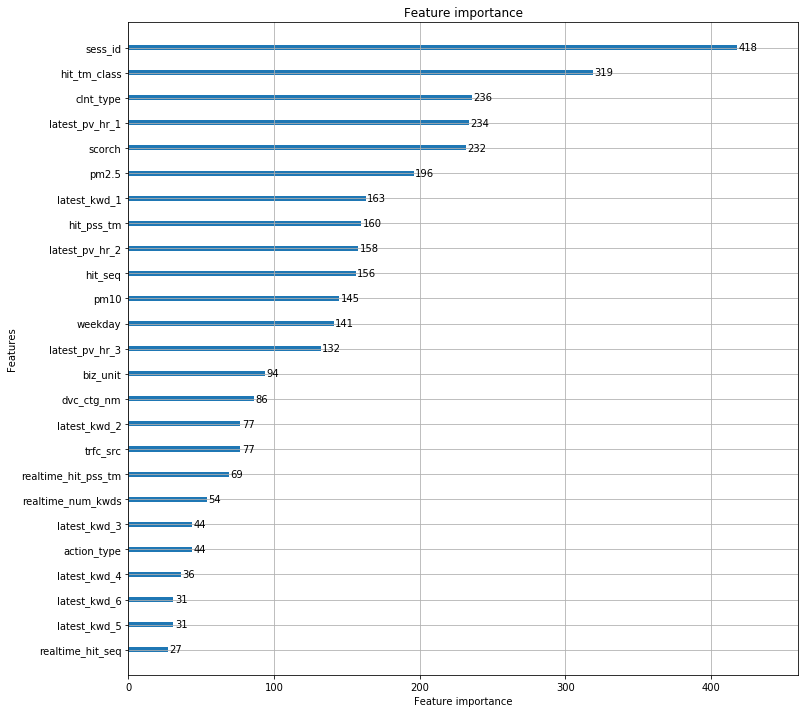

In [6]:
lgb.plot_importance(lgb_model, figsize = (12, 12))

### 정확도 측정
- 세션 내 구매 이전의 행동에 대한 구매상품결과가 실제로 구매했던 품목에 포함되어 있는 경우 예측에 성공한 것으로 간주합니다.
- 그 결과 약 60%의 정확도를 보였습니다. 
    - 이는 곧 트래커모델로부터 얻은 고객유형과 네비게이터모델의 실시간 행동패턴과 과거 행동 패턴, 날짜에 따른 부가정보가 구매상품 예측에 핵심 변수로 작용하고 있음을 의미합니다.

In [ ]:
# 위 과정에 따라 학습된 모델 불러오기
lgb_model = joblib.load('./navigator/lgb_model_final.pkl')
test_x = pd.read_csv('./navigator/navigator_for_scoring_X.csv')
test_y = pd.read_csv('./navigator/navigator_for_scoring_y.csv')

In [93]:
# 예측 정확도를 측정하기 위해 마련한 고객별 ID 정보 및 실제 구매상품
id_for_test_x = df_navigator.loc[test_x.index, ['clnt_id', 'sess_id', 'buy_id', 'target']].reset_index(drop = True)
id_for_test_x.to_csv('./navigator/navigator_for_scoring_id.csv', index = False)

# 데이터 불러오기
id_for_test_x = pd.read_csv('./navigator/navigator_for_scoring_id.csv')

In [94]:
# 정확도 측정을 위한 함수
def is_correct(df):
    target_list = df['target'].unique()
    for i in df.index:
        if df['pred'].loc[i] in target_list:
            df.loc[i, 'is_correct'] = 1
    return df

In [95]:
pred = lgb_model.predict(test_x)
df_pred = pd.DataFrame(pred).apply(lambda x: x.idxmax(), axis=1)
id_for_test_x.reset_index(drop = True, inplace = True)
id_for_test_x['pred'] = df_pred
id_for_test_x.sort_values(by = ['clnt_id', 'sess_id', 'buy_id'], inplace = True)
id_for_test_x.reset_index(drop = True, inplace = True)

In [96]:
id_for_test_x['is_correct'] = 0

In [97]:
output = id_for_test_x.groupby(['clnt_id', 'sess_id', 'buy_id']).apply(lambda x: is_correct(x))

In [98]:
# is_correct가 0인 경우 오답, is_correct가 1인 경우 정답
output[['clnt_id', 'sess_id', 'target', 'is_correct']].head()

,clnt_id,sess_id,target,is_correct
0,2.0,1.0,4,0
1,2.0,1.0,4,0
2,2.0,1.0,4,0
3,2.0,1.0,4,0
4,2.0,1.0,4,0


In [99]:
print(f"정확도: {output['is_correct'].mean()*100}%")

정확도: 52.86542923433875%


(\*위 결과는 1만개 데이터로 학습, 예측하였을 경우 도출된 정확도입니다.)

In [7]:
output.to_csv('./navigator/navigator_output.csv')

### 소분류 상품 예측을 통한 세부 항목 추천: 네비게이터 모델의 최종 목표!
- 최종의 소분류 상품 예측을 위해 이제는 기존의 대분류(`clac_nm1`) target 변수를 특징 변수로서 활용하며, 타겟 변수는 소분류 구매상품정보가 됩니다.

In [5]:
# 데이터 불러오기
df_navigator = pd.read_csv('./navigator/#8 df_navigator_encoded.csv')

- clac_nm1, clac_nm3 변수의 인코딩 적용

In [15]:
from sklearn.preprocessing import LabelEncoder

# clac_nm1 인코딩
encoder_clac1 = LabelEncoder()
encoder_clac1.fit(np.load('./navigator/encoder_clac1.npy', allow_pickle = True))
temp = df_navigator[df_navigator['clac_nm1'].notnull()].index
df_navigator.loc[temp, 'clac_nm1'] = encoder_clac1.transform(df_navigator.loc[temp, 'clac_nm1'])

# clac_nm3 인코딩
encoder_clac3 = LabelEncoder()
# encoder_clac3.fit(df4item[df4item['clac_nm3'].notnull()]['clac_nm3'])
# np.save('./navigator/encoder_clac3.npy', encoder_clac3.classes_)
encoder_clac3.fit(np.load('./navigator/encoder_clac3.npy', allow_pickle = True))
# temp = df_navigator[df_navigator['clac_nm3'].notnull()].index
df_navigator.loc[temp, 'clac_nm3'] = encoder_clac3.transform(df_navigator.loc[temp, 'clac_nm3'])


# df_navigator.head()

LabelEncoder()

In [101]:
df_navigator['target_clac3'] = -1

In [102]:
# buy_id로 그룹화
def target_merge_clac3(df):
    target_list = df['target'].unique()
    for t in target_list:
        c3 = df[df['clac_nm1']==t]['clac_nm3']
        if len(c3) > 0:
            temp_idx = list(df[df['target'] == t].index)
            df.loc[temp_idx,'target_clac3'] = c3.iloc[0]
    return df

In [103]:
df_target_clac3 = df_navigator.groupby(['clnt_id', 'sess_id', 'buy_id']).apply(lambda x: target_merge_clac3(x))
df_target_clac3 = df_target_clac3[df_target_clac3['target_clac3']!=-1].drop(['clac_nm1', 'clac_nm2', 'clac_nm3'], axis = 1)
df_target_clac3.head()

,clnt_id,clnt_type,sess_id,buy_id,hit_seq,action_type,biz_unit,trans_id,sess_dt,hit_pss_tm,trfc_src,dvc_ctg_nm,hit_tm_class,realtime_hit_pss_tm,realtime_hit_seq,realtime_num_kwds,latest_kwd_1,latest_kwd_2,latest_kwd_3,latest_kwd_4,latest_kwd_5,latest_kwd_6,latest_pv_hr_1,latest_pv_hr_2,latest_pv_hr_3,scorch,pm2.5,pm10,weekday,target,target_clac3
0,2.0,1.0,1.0,1,1.0,0.0,2,NaN,20190728,39532.0,0,3,23,39532.0,1.0,0,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,25,9,14,6,4,Coffee Drinks
1,2.0,1.0,1.0,1,2.0,1.0,2,NaN,20190728,47232.0,0,3,23,47232.0,2.0,1,31143,-1,-1,-1,-1,-1,0.0,0.0,0.0,25,9,14,6,4,Coffee Drinks
2,2.0,1.0,1.0,1,3.0,2.0,2,NaN,20190728,48087.0,0,3,23,48087.0,3.0,1,31143,-1,-1,-1,-1,-1,0.0,0.0,0.0,25,9,14,6,4,Coffee Drinks
3,2.0,1.0,1.0,1,4.0,0.0,2,NaN,20190728,62794.0,0,3,23,62794.0,4.0,1,31143,-1,-1,-1,-1,-1,0.0,0.0,0.0,25,9,14,6,4,Coffee Drinks
4,2.0,1.0,1.0,1,5.0,0.0,2,NaN,20190728,104074.0,0,3,23,104074.0,5.0,2,31143,31143,-1,-1,-1,-1,0.0,0.0,0.0,25,9,14,6,4,Coffee Drinks


- 데이터 저장

In [ ]:
df_target_clac3.to_csv('./navigator/# df_target_clac3.csv', index = False)

- 저장된 데이터 불러오기

In [8]:
df_target_clac3 = pd.read_csv('./navigator/# df_target_clac3.csv')

#### 모델링

In [2]:
import lightgbm as lgb
import joblib
from sklearn.model_selection import train_test_split

- 학습데이터 생성

In [104]:
train_fts = df_target_clac3[['clnt_type', 'sess_id', 'hit_seq', 'action_type', 'biz_unit','hit_pss_tm', 'trfc_src', 'dvc_ctg_nm', 'hit_tm_class',
                             'realtime_hit_pss_tm', 'realtime_hit_seq', 'realtime_num_kwds',
                             'latest_kwd_1', 'latest_kwd_2', 'latest_kwd_3', 'latest_kwd_4','latest_kwd_5', 'latest_kwd_6', 
                             'latest_pv_hr_1', 'latest_pv_hr_2', 'latest_pv_hr_3', 'scorch', 'pm2.5', 'pm10', 'weekday', 'target']]
train_trg = df_target_clac3['target_clac3']
train_fts.head()

,clnt_type,sess_id,hit_seq,action_type,biz_unit,hit_pss_tm,trfc_src,dvc_ctg_nm,hit_tm_class,realtime_hit_pss_tm,realtime_hit_seq,realtime_num_kwds,latest_kwd_1,latest_kwd_2,latest_kwd_3,latest_kwd_4,latest_kwd_5,latest_kwd_6,latest_pv_hr_1,latest_pv_hr_2,latest_pv_hr_3,scorch,pm2.5,pm10,weekday,target
0,1.0,1.0,1.0,0.0,2,39532.0,0,3,23,39532.0,1.0,0,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,25,9,14,6,4
1,1.0,1.0,2.0,1.0,2,47232.0,0,3,23,47232.0,2.0,1,31143,-1,-1,-1,-1,-1,0.0,0.0,0.0,25,9,14,6,4
2,1.0,1.0,3.0,2.0,2,48087.0,0,3,23,48087.0,3.0,1,31143,-1,-1,-1,-1,-1,0.0,0.0,0.0,25,9,14,6,4
3,1.0,1.0,4.0,0.0,2,62794.0,0,3,23,62794.0,4.0,1,31143,-1,-1,-1,-1,-1,0.0,0.0,0.0,25,9,14,6,4
4,1.0,1.0,5.0,0.0,2,104074.0,0,3,23,104074.0,5.0,2,31143,31143,-1,-1,-1,-1,0.0,0.0,0.0,25,9,14,6,4


- 아래와 같이 소분류는 총 1662가지가 있습니다.

In [105]:
df4item = pd.read_csv('./DATA/상품분류 정보(CKS).csv', dtype=cks_dtype)
df4item['clac_nm3'].nunique()

1662

In [106]:
train_x, test_x, train_y, test_y = train_test_split(train_fts, train_trg, test_size = 0.2, shuffle = True, random_state = 613)

In [ ]:
# train_x.to_csv('./navigator/# df_train_X_clac3.csv', index = False)
# train_y.to_frame().reset_index(drop = True).to_csv('./navigator/# df_train_y_clac3.csv', index = False)

# test_x.to_csv('./navigator/# df_test_X_clac3.csv', index = False)
# test_y.to_frame().reset_index(drop = True).to_csv('./navigator/# df_test_y_clac3.csv', index = False)

# train_x =pd.read_csv('./navigator/# df_train_X_clac3.csv')
# train_y=pd.read_csv('./navigator/# df_train_y_clac3.csv')

# test_x=pd.read_csv('./navigator/# df_test_X_clac3.csv')
# test_y=pd.read_csv('./navigator/# df_test_y_clac3.csv')

In [107]:
# 파라미터 설정
params = {
    'boosting_type': 'goss',
    'objective': 'multiclass',
    'num_class':1663,
    'metric': 'softmax'
    }
predictors = train_x.columns.tolist()
dtrain = lgb.Dataset(train_x.head(100000).values, label=train_y.head(100000), feature_name=predictors)
dvalid = lgb.Dataset(test_x.head(50000).values, label=test_y.head(50000), feature_name=predictors)

In [108]:
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      early_stopping_rounds=50, # typical
                      num_boost_round=1000,
                      valid_sets=[dvalid],
                      verbose_eval=False
                     )

- 모델 저장

In [ ]:
joblib.dump(lgb_model, './navigator/lgb_model_clac3_final.pkl')

In [109]:
# 재현시 해당 모델을 불러온다.
lgb_model = joblib.load('./navigator/lgb_model_clac3_final.pkl')

- 전체 train데이터에 대한 target을 예측합니다.

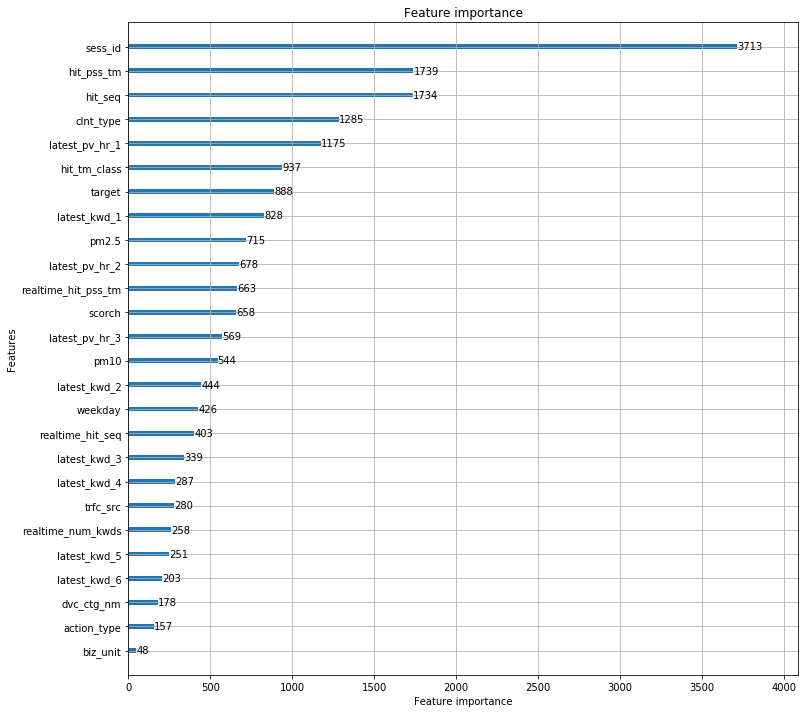

In [110]:
lgb.plot_importance(lgb_model, figsize = (12, 12))

In [16]:
test_y.to_frame('y').to_csv('검증타겟.csv', index = False)

In [111]:
pred = lgb_model.predict(test_x)

In [112]:
len(test_y)

5512

In [114]:
success_list = []
for idx, t in enumerate(test_y['y']):
    try:
        if int(t) in for_accuracy[idx]:
            success_list.append((idx, t))
    except:
        pass

In [62]:
len(success_list) / len(test_y)

0.494845520521102

소분류 예측의 경우 위와 같이 약 50%의 정확도를 보입니다.

### 식별화된 비회원에 대한 상품 추천

- 식별화된 비회원 데이터를 불러옵니다.

In [6]:
# 비회원 학습데이터
train_unknown = pd.read_csv('./navigator/# 식별화된 비회원 데이터_final_for_predict.csv')

# 위 비회원 학습데이터에 대한 clnt_id

In [7]:
train_unknown.head()

,clnt_type,sess_id,hit_seq,action_type,biz_unit,hit_pss_tm,trfc_src,dvc_ctg_nm,hit_tm_class,realtime_num_kwds,realtime_hit_pss_tm,latest_kwd_1,latest_kwd_2,latest_kwd_3,latest_kwd_4,latest_kwd_5,latest_kwd_6,latest_pv_hr_1,latest_pv_hr_2,latest_pv_hr_3,realtime_hit_seq,scorch,pm2.5,pm10,weekday
0,2,1,1,0,0,11880,6,1,16,0,11880.0,-1,-1,-1,-1,-1,-1,0.000000,0.0,0.0,1.0,25,4,8,2
1,2,1,2,0,0,22432,6,1,16,1,22432.0,15133,-1,-1,-1,-1,-1,0.000000,0.0,0.0,2.0,25,4,8,2
2,2,1,3,0,0,36140,6,1,16,2,36140.0,15134,15133,-1,-1,-1,-1,0.000000,0.0,0.0,3.0,25,4,8,2
3,2,2,1,0,0,41584,6,1,14,0,41584.0,-1,-1,-1,-1,-1,-1,0.112903,0.0,0.0,1.0,16,3,6,6
4,2,2,2,0,0,56113,6,1,14,1,56113.0,81935,-1,-1,-1,-1,-1,0.112903,0.0,0.0,2.0,16,3,6,6


In [8]:
train_unknown.columns

Index(['clnt_type', 'sess_id', 'hit_seq', 'action_type', 'biz_unit',
       'hit_pss_tm', 'trfc_src', 'dvc_ctg_nm', 'hit_tm_class',
       'realtime_num_kwds', 'realtime_hit_pss_tm', 'latest_kwd_1',
       'latest_kwd_2', 'latest_kwd_3', 'latest_kwd_4', 'latest_kwd_5',
       'latest_kwd_6', 'latest_pv_hr_1', 'latest_pv_hr_2', 'latest_pv_hr_3',
       'realtime_hit_seq', 'scorch', 'pm2.5', 'pm10', 'weekday'],
      dtype='object')

#### 대분류 구매 상품 상품 예측
- 대분류 상품 예측 모델을 불러오고 예측합니다.

In [47]:
from sklearn.preprocessing import LabelEncoder
encoder_clac1 = LabelEncoder()
encoder_clac1.fit(np.load('./navigator/encoder_clac1.npy', allow_pickle = True))
encoder_clac3 = LabelEncoder()
encoder_clac3.fit(np.load('./navigator/encoder_clac3.npy', allow_pickle = True))

LabelEncoder()

In [4]:
lgb_model_clac1 = joblib.load('./navigator/lgb_model_final.pkl')

In [16]:
# 구매 상품 대분류 예측
target = lgb_model_clac1.predict(train_unknown)
target = pd.DataFrame(target).apply(lambda x: x.idxmax(), axis=1)

target = target.to_frame('target')
target['target'] = encoder_clac1.inverse_transform(target['target'])

* 구매 대분류 예측 결과는 다음과 같습니다.

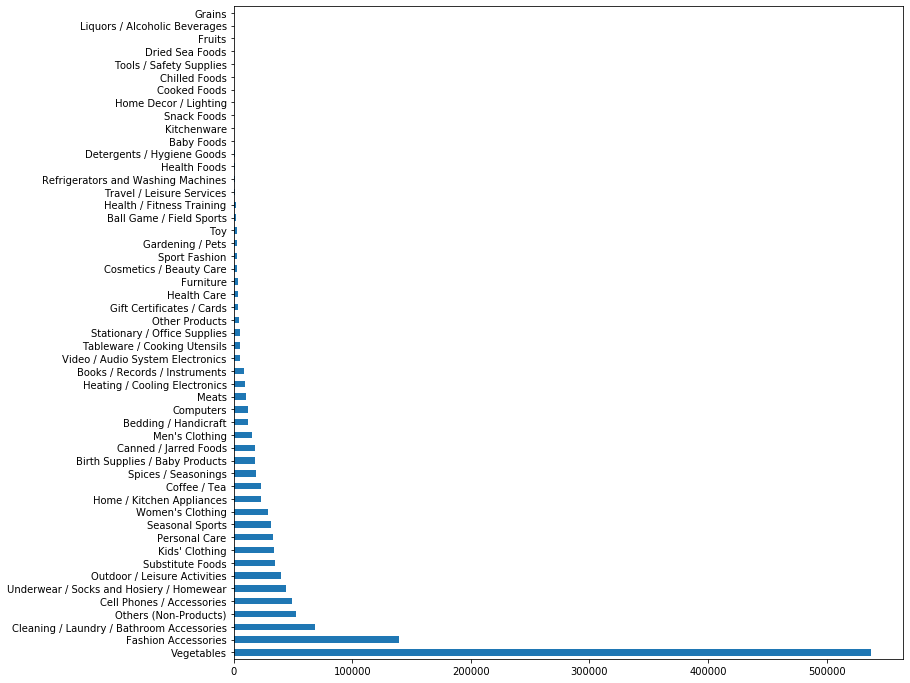

In [35]:
target['target'].value_counts(ascending = False).plot(kind = 'barh', figsize = (12,12))

In [ ]:
target.to_csv('./navigator/비회원 대분류 예측 결과.csv', index= False)

#### 소분류 상품 예측 및 추천

- 위의 예측한 타겟을 기존 학습데이터(train_unknown)의 변수로 추가합니다

In [36]:
train_unknown_clac3 = pd.concat([train_unknown, target['target']],  axis = 1)

In [41]:
from sklearn.preprocessing import LabelEncoder
encoder_clac1 = LabelEncoder()
encoder_clac1.fit(np.load('./navigator/encoder_clac1.npy', allow_pickle = True))

train_unknown_clac3['target'] = encoder_clac1.transform(train_unknown_clac3['target'])

In [42]:
train_unknown_clac3.head()

,clnt_type,sess_id,hit_seq,action_type,biz_unit,hit_pss_tm,trfc_src,dvc_ctg_nm,hit_tm_class,realtime_num_kwds,realtime_hit_pss_tm,latest_kwd_1,latest_kwd_2,latest_kwd_3,latest_kwd_4,latest_kwd_5,latest_kwd_6,latest_pv_hr_1,latest_pv_hr_2,latest_pv_hr_3,realtime_hit_seq,scorch,pm2.5,pm10,weekday,target
0,2,1,1,0,0,11880,6,1,16,0,11880.0,-1,-1,-1,-1,-1,-1,0.000000,0.0,0.0,1.0,25,4,8,2,3
1,2,1,2,0,0,22432,6,1,16,1,22432.0,15133,-1,-1,-1,-1,-1,0.000000,0.0,0.0,2.0,25,4,8,2,18
2,2,1,3,0,0,36140,6,1,16,2,36140.0,15134,15133,-1,-1,-1,-1,0.000000,0.0,0.0,3.0,25,4,8,2,18
3,2,2,1,0,0,41584,6,1,14,0,41584.0,-1,-1,-1,-1,-1,-1,0.112903,0.0,0.0,1.0,16,3,6,6,3
4,2,2,2,0,0,56113,6,1,14,1,56113.0,81935,-1,-1,-1,-1,-1,0.112903,0.0,0.0,2.0,16,3,6,6,18


In [37]:
lgb_model_clac3 = joblib.load('./navigator/lgb_model_clac3_final.pkl')

In [43]:
target_clac3 = lgb_model_clac3.predict(train_unknown_clac3)

In [45]:
recommend_list = []
for i in range(target_clac3.shape[0]):
    recommend_list.append(list(pd.Series(target_clac3[i]).sort_values(ascending = False).head(6).index))

In [46]:
recommend_df = pd.DataFrame(np.array(recommend_list), columns = ['추천상품1' ,'추천상품2', '추천상품3', '추천상품4', '추천상품5', '추천상품6'])
recommend_df.head()

,추천상품1,추천상품2,추천상품3,추천상품4,추천상품5,추천상품6
0,800,583,575,1026,5,9
1,800,583,449,869,1605,1117
2,800,583,449,869,1605,1117
3,800,583,575,63,5,745
4,800,583,449,63,745,869


In [49]:
recommend_df.to_csv('./navigator/# 잠재고객 추천상품 데이터프레임_encoded.csv', index = False)

- 고객 행동별 실시간 상품추천 결과

In [50]:
ids = pd.read_csv('./navigator/# 식별화된 비회원 데이터_id정보.csv')
pd.concat([ids, recommend_df], axis= 1).head()

,clnt_id,sess_id,추천상품1,추천상품2,추천상품3,추천상품4,추천상품5,추천상품6
0,1,1,800,583,575,1026,5,9
1,1,1,800,583,449,869,1605,1117
2,1,1,800,583,449,869,1605,1117
3,1,2,800,583,575,63,5,745
4,1,2,800,583,449,63,745,869


In [55]:
pd.concat([ids, recommend_df], axis= 1).shape

(1317822, 8)

* 추천 상품 데이터 저장

In [ ]:
pd.concat([ids, recommend_df], axis= 1).to_csv('./navigator/# 잠재고객 추천상품 데이터프레임_id_encoded.csv', index = False)

In [61]:
pd.concat([ids, train_unknown_clac3[['clnt_type', 'sess_id', 'hit_seq', 'target']], recommend_df], axis = 1).columns

Index(['clnt_id', 'sess_id', 'clnt_type', 'sess_id', 'hit_seq', 'target',
       '추천상품1', '추천상품2', '추천상품3', '추천상품4', '추천상품5', '추천상품6'],
      dtype='object')

In [66]:
pd.concat([ids, train_unknown_clac3[['clnt_type', 'sess_id', 'hit_seq', 'target']], recommend_df], axis = 1)

,clnt_id,sess_id,clnt_type,sess_id,hit_seq,target,추천상품1,추천상품2,추천상품3,추천상품4,추천상품5,추천상품6
0,1,1,2,1,1,3,800,583,575,1026,5,9
1,1,1,2,1,2,18,800,583,449,869,1605,1117
2,1,1,2,1,3,18,800,583,449,869,1605,1117
3,1,2,2,2,1,3,800,583,575,63,5,745
4,1,2,2,2,2,18,800,583,449,63,745,869
...,...,...,...,...,...,...,...,...,...,...,...,...
1317817,72428,3,2,3,3,32,583,63,1089,869,479,172
1317818,72428,4,2,4,1,32,583,63,1094,1089,723,496
1317819,72428,5,2,5,1,3,845,583,105,575,5,292
1317820,72429,1,2,1,1,57,1043,820,768,344,318,395


In [78]:
final_df = pd.DataFrame(pd.concat([ids, train_unknown_clac3[['clnt_type', 'sess_id', 'hit_seq', 'target']], recommend_df], axis = 1))
final_df = final_df[['clnt_id', 'sess_id', 'sess_id', 'hit_seq', 'clnt_type', 'target', '추천상품1', '추천상품2', '추천상품3', '추천상품4', '추천상품5', '추천상품6']]
final_df.head()

,clnt_id,sess_id,sess_id,sess_id,sess_id,hit_seq,clnt_type,target,추천상품1,추천상품2,추천상품3,추천상품4,추천상품5,추천상품6
0,1,1,1,1,1,1,2,3,800,583,575,1026,5,9
1,1,1,1,1,1,2,2,18,800,583,449,869,1605,1117
2,1,1,1,1,1,3,2,18,800,583,449,869,1605,1117
3,1,2,2,2,2,1,2,3,800,583,575,63,5,745
4,1,2,2,2,2,2,2,18,800,583,449,63,745,869


In [74]:
final_df.to_csv('유형 포함 결과물.csv', index = False)

* 다음은 트래커 모델에 의해 예측된 고객유형(`clnt_type`)을 기반으로 6개의 상품을 추천한 결과물입니다.

In [79]:
final_df['추천상품1'] = encoder_clac3.inverse_transform(final_df['추천상품1'])
final_df['추천상품2'] = encoder_clac3.inverse_transform(final_df['추천상품2'])
final_df['추천상품3'] = encoder_clac3.inverse_transform(final_df['추천상품3'])
final_df['추천상품4'] = encoder_clac3.inverse_transform(final_df['추천상품4'])
final_df['추천상품5'] = encoder_clac3.inverse_transform(final_df['추천상품5'])
final_df['추천상품6'] = encoder_clac3.inverse_transform(final_df['추천상품6'])
final_df['target'] = encoder_clac1.inverse_transform(final_df['target'])
final_df.head()

,clnt_id,sess_id,sess_id,sess_id,sess_id,hit_seq,clnt_type,target,추천상품1,추천상품2,추천상품3,추천상품4,추천상품5,추천상품6
0,1,1,1,1,1,1,2,Bedding / Handicraft,Kids' Thermal Underwear,General Vecuum Cleaners,General Mats,Nail Sets,Adult's Bed Covers and Skirts,Adults' Bedding Sets
1,1,1,1,1,1,2,2,Fashion Accessories,Kids' Thermal Underwear,General Vecuum Cleaners,Earrings,Liquior Cups / Glasses,Women's Loafer,Other Men's Footwear
2,1,1,1,1,1,3,2,Fashion Accessories,Kids' Thermal Underwear,General Vecuum Cleaners,Earrings,Liquior Cups / Glasses,Women's Loafer,Other Men's Footwear
3,1,2,2,2,2,1,2,Bedding / Handicraft,Kids' Thermal Underwear,General Vecuum Cleaners,General Mats,Baby Bath Products,Adult's Bed Covers and Skirts,Irons
4,1,2,2,2,2,2,2,Fashion Accessories,Kids' Thermal Underwear,General Vecuum Cleaners,Earrings,Baby Bath Products,Irons,Liquior Cups / Glasses
